In [1]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce

In [2]:
with open('../pickle_files/clustering1.pkl', 'rb') as f:
    clustering_result = pickle.load(f)
    player_cluster_dict = pickle.load(f)
    players_grouped_by_cluster_dict = pickle.load(f)

In [3]:
for k, cluster in players_grouped_by_cluster_dict.items():
    for name in cluster:
        if len(name.split()) > 2:
            print(k, name)

9 Kelly Oubre Jr.
3 Johnny O'Bryant III
3 Larry Nance Jr.
12 Otto Porter Jr.
12 Metta World Peace


In [4]:
confusing_name_list = ["JaMychal Green", "Jeff Green",
                        "Draymond Green", "Danny Green", 
                        "Stephen Curry", "Seth Curry", 
                        "Marcus Morris", "Markieff Morris",
                        "JR Smith", "Jason Smith", "Josh Smith",
                        "James Johnson", "Joe Johnson",
                        "Deron Williams", "Derrick Williams",
                        "Marvin Williams", "Mo Williams",
                        "Trae Young", "Thaddeus Young",
                        "Jerami Grant", "Jerian Grant"
                        ]

In [5]:
df_name_cluster = pd.DataFrame(columns=["name", "cluster"])
last_name_list = []
for k, cluster in players_grouped_by_cluster_dict.items():
    cluster_df = pd.DataFrame(columns=["name", "cluster"])
    for i, player_name in enumerate(cluster):
        if player_name == "Nene":
            cluster_df.loc[i, "name"] = player_name
            cluster_df.loc[i, "cluster"] = k
        elif len(player_name.split()) > 2:
            first_name, last_name, etc = player_name.split()[0], player_name.split()[1], player_name.split()[2]
            cluster_df.loc[i, "name"] = first_name[0]+". "+last_name+" "+etc
            cluster_df.loc[i, "cluster"] = k
        elif player_name in confusing_name_list:
            cluster_df.loc[i, "name"] = player_name
            cluster_df.loc[i, "cluster"] = k
        else:
            first_name, last_name = player_name.split()[0], player_name.split()[1]
            last_name_list.append(last_name)
            cluster_df.loc[i, "name"] = first_name[0]+". "+last_name
            cluster_df.loc[i, "cluster"] = k
    df_name_cluster = pd.concat([df_name_cluster, cluster_df])
df_name_cluster

,name,cluster
0,K. Lowry,6
1,K. Walker,6
2,B. Roberts,6
3,J. Wall,6
4,L. Williams,6
...,...,...
8,R. Holmes,4
9,J. Parker,4
10,J. Lauvergne,4
11,N. Vonleh,4


In [7]:
lineups_dict = {}
for y in range(13, 20):
    lineups = pd.read_csv("../NBA.com_Stats/Lineups/Advanced/20"+str(y-1)+"-"+str(y)+"_NBA_Lineups_Advanced.csv")
    teams = pd.read_csv("../NBA.com_Stats/Teams/Advanced/20"+str(y-1)+"-"+str(y)+"_NBA_Teams_Advanced.csv")
    lineups_dict[y] = pd.merge(lineups, teams, on="TEAM", how="left")


In [8]:
for lineups in lineups_dict.values():
    for i, min in enumerate(lineups["MIN_x"]):
        if min < 300:
            lineups.loc[i, "OFFRTG"] = lineups.loc[i, "OFFRTG_x"]*(min/300) + lineups.loc[i, "OFFRTG_y"]*(1-(min/300))  
        else:
            lineups.loc[i, "OFFRTG"] = lineups.loc[i, "OFFRTG_x"]
lineups_dict[15]["OFFRTG"]   

0      119.100000
1      109.300000
2      115.200000
3      107.900000
4      105.500000
          ...    
336    106.300000
337    105.216667
338    105.466667
339    107.933333
340    104.616667
Name: OFFRTG, Length: 341, dtype: float64

In [9]:
OFFRTG_df = pd.DataFrame(columns=["OFFRTG_x", "OFFRTG"])

In [10]:
for y, lineups in lineups_dict.items():
    OFFRTG_df = pd.concat([OFFRTG_df, lineups[["OFFRTG_x", "OFFRTG"]]])
OFFRTG_df

,OFFRTG_x,OFFRTG
0,109.5,109.500000
1,109.0,109.000000
2,104.8,104.800000
3,108.0,108.000000
4,113.2,113.200000
...,...,...
334,86.2,109.116667
335,116.7,108.366667
336,126.0,112.833333
337,105.7,109.866667


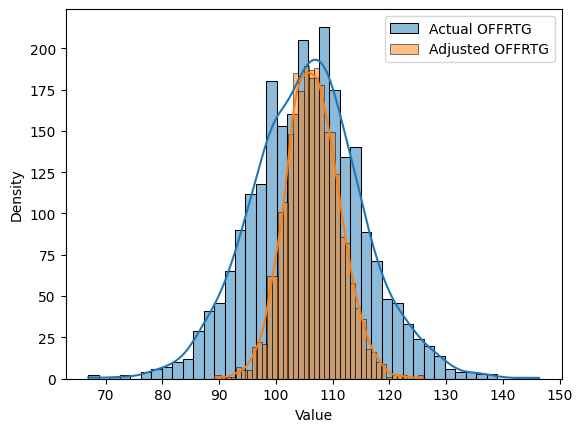

In [11]:
sns.histplot(OFFRTG_df["OFFRTG_x"],kde=True, label="Actual OFFRTG")
sns.histplot(OFFRTG_df["OFFRTG"],kde=True, label="Adjusted OFFRTG")
plt.title("")
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.show()

In [12]:
for y, lineups in lineups_dict.items():
    for i, lineup in lineups.iterrows():
        morris_count = 0
        m_williams_count = 0
        for n in range(1, 6):
            player_name = lineup["PLAYER"+str(n)]
            if player_name[-1] == " ":
                player_name = player_name[:-1]
            if player_name[0] == " ":
                player_name = player_name[1:]
        
            if player_name == "J. Green":
                if y > 16 and lineup["TEAM"] == "MEM":
                    player_name = "JaMychal Green"
                else:
                    player_name = "Jeff Green"
            if player_name == "D. Green":
                if lineup["TEAM"] == "GSW":
                    player_name = "Draymond Green"
                else:
                    player_name = "Danny Green"
            if player_name == "S. Curry":
                if lineup["TEAM"] == "GSW":
                    player_name = "Stephen Curry"
                else:
                    player_name = "Seth Curry"
            if player_name == "M. Morris":
                if lineup["TEAM"] == "HOU" or lineup["TEAM"] == "DET" or lineup["TEAM"] == "BOS":
                    player_name = "Marcus Morris"
                elif lineup["TEAM"] == "WAS":
                    player_name = "Markieff Morris"
                else:
                    morris_count += 1
                    if morris_count == 1:
                        player_name = "Marcus Morris"
                    else: 
                        player_name = "Markieff Morris"
            if player_name == "J. Smith":
                if (y == 14 and lineup["TEAM"] == "NYK") or lineup["TEAM"] == "CLE":
                    player_name = "JR Smith"
                elif (y == 15 and lineup["TEAM"] == "NYK") or lineup["TEAM"] == "ORL" or lineup["TEAM"] == "WAS" or lineup["TEAM"] == "MIL":
                    player_name = "Jason Smith"
                else:
                    player_name = "Josh Smith"
            if player_name == "J. Johnson":
                if lineup["TEAM"] == "SAC" or lineup["TEAM"] == "TOR" or (y >= 17 and lineup["TEAM"] == "MIA"):
                    player_name = "James Johnson"
                else:
                    player_name = "Joe Johnson"
            if player_name == "D. Williams":
                if lineup["TEAM"] == "BKN" or lineup["TEAM"] == "DAL": 
                    player_name = "Deron Williams"
                else:
                    player_name = "Derrick Williams"
            if player_name == "M. Williams":
                if lineup["TEAM"] == "CHA" or (y == 14 and lineup["TEAM"] == "UTA"): 
                    player_name = "Marvin Williams"
                elif y == 13 and lineup["TEAM"] == "UTA":
                    m_williams_count += 1
                    if m_williams_count == 1:
                        player_name = "Marvin Williams"
                    else:
                        player_name = "Mo Williams"
                else:
                    player_name = "Mo Williams"
            if player_name == "T. Young":
                if lineup["TEAM"] == "ATL": 
                    player_name = "Trae Young"
                else:
                    player_name = "Thaddeus Young"
            if player_name == "J. Grant":
                if lineup["TEAM"] == "PHI" or lineup["TEAM"] == "OKC":
                    player_name = "Jerami Grant"
                else:
                    player_name = "Jerian Grant"
            print(player_name)
            if i == 5 and (morris_count == 1 or m_williams_count == 1):
                continue    
            lineups.loc[i, "PLAYER"+str(n)] = player_name

K. Perkins
T. Sefolosha
K. Durant
R. Westbrook
S. Ibaka
D. West
R. Hibbert
G. Hill
P. George
L. Stephenson
L. Aldridge
J. Hickson
N. Batum
W. Matthews
D. Lillard
A. Iguodala
D. Gallinari
K. Koufos
T. Lawson
K. Faried
C. Butler
W. Green
C. Paul
D. Jordan
B. Griffin
L. James
C. Bosh
D. Wade
U. Haslem
M. Chalmers
Joe Johnson
G. Wallace
R. Evans
Deron Williams
B. Lopez
Z. Randolph
T. Allen
R. Gay
M. Conley
M. Gasol
T. Prince
J. Maxiell
G. Monroe
B. Knight
K. Singler
J. Salmons
J. Thompson
T. Evans
D. Cousins
I. Thomas
O. Asik
J. Harden
P. Patterson
J. Lin
C. Parsons
Z. Randolph
T. Prince
T. Allen
M. Conley
M. Gasol
D. Lee
Stephen Curry
K. Thompson
H. Barnes
F. Ezeli
E. Gordon
R. Lopez
A. Aminu
G. Vasquez
A. Davis
J. Tinsley
A. Jefferson
Marvin Williams
R. Foye
P. Millsap
L. Scola
M. Gortat
P. Tucker
J. Dudley
G. Dragic
R. Hamilton
C. Boozer
K. Hinrich
L. Deng
J. Noah
A. Bogut
D. Lee
Stephen Curry
K. Thompson
H. Barnes
A. Gee
K. Irving
T. Thompson
D. Waiters
T. Zeller
J. Jack
D. Lee
C. Land

In [13]:
lineups_dict[16] = lineups_dict[16].dropna(axis=1)
lineups_dict[16]

,LINEUPS,TEAM,GP_x,MIN_x,OFFRTG_x,DEFRTG_x,NETRTG_x,AST%_x,AST/TO_x,AST RATIO_x,...,OREB%_y,DREB%_y,REB%_y,TOV%,EFG%_y,TS%_y,PACE_y,PIE_y,POSS,OFFRTG
0,E. Ilyasova - M. Morris - R. Jackson - A. Drum...,DET,48,915,105.2,101.5,3.8,48.1,1.45,14.3,...,31.3,75.3,52.1,14.0,49.1,52.2,95.75,48.6,"7,942",105.200000
1,K. Korver - P. Millsap - A. Horford - J. Teagu...,ATL,70,892,104.3,100.5,3.8,70.8,1.94,20.5,...,23.4,69.8,47.4,15.2,51.6,55.2,97.63,52.8,"8,059",104.300000
2,K. Durant - R. Westbrook - S. Ibaka - A. Rober...,OKC,59,816,114.3,96.5,17.8,61.9,1.82,19.4,...,34.7,72.0,54.1,16.2,52.4,56.5,97.54,54.6,"8,061",114.300000
3,C. Anthony - J. Calderon - A. Afflalo - R. Lop...,NYK,50,735,103.6,105.9,-2.3,50.1,1.41,15.3,...,28.0,71.8,50.2,14.2,48.3,52.7,94.12,48.7,"7,763",103.600000
4,A. Johnson - A. Bradley - I. Thomas - J. Sulli...,BOS,60,723,106.4,104.1,2.4,67.9,2.23,19.8,...,29.0,70.7,49.5,13.8,48.8,53.1,99.43,52.0,"8,191",106.400000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349,K. Humphries - T. Sefolosha - P. Millsap - D. ...,ATL,20,50,99.0,96.0,3.0,60.0,1.91,15.6,...,23.4,69.8,47.4,15.2,51.6,55.2,97.63,52.8,"8,059",103.666667
350,L. Thomas - D. Williams - K. Porzingis - L. Ga...,NYK,18,50,82.9,91.0,-8.1,56.3,1.06,13.8,...,28.0,71.8,50.2,14.2,48.3,52.7,94.12,48.7,"7,763",100.400000
351,M. Williams - S. Hawes - J. Lin - J. Lamb - C....,CHA,9,50,92.5,94.2,-1.8,67.6,1.25,17.7,...,24.4,75.4,49.9,12.9,50.2,54.5,96.24,51.1,"7,966",104.083333
352,N. Bjelica - G. Dieng - S. Muhammad - Z. LaVin...,MIN,19,50,105.0,105.7,-0.7,55.3,1.17,15.6,...,27.9,70.2,49.4,15.5,49.8,54.9,96.20,49.7,"7,965",105.333333


In [39]:
with open('../pickle_files/lineups_dict1.pkl', 'wb') as f:
    pickle.dump(lineups_dict, f)

In [15]:
lineup_cluster_dict = {}
for y, lineups in lineups_dict.items():
    for n in range(1, 6):
        df = df_name_cluster.rename(columns={"name": 'PLAYER'+str(n), "cluster": "CLUSTER"+str(n)})
        lineups = pd.merge(lineups, df, on="PLAYER"+str(n), how="left")
    lineups = lineups.dropna()
    lineup_cluster_dict[y] = lineups

In [16]:
lineup_cluster_dict[13]["Season"] = "2012-13"
lineup_cluster_dict[14]["Season"] = "2013-14"
lineup_cluster_dict[15]["Season"] = "2014-15"
lineup_cluster_dict[16]["Season"] = "2015-16"
lineup_cluster_dict[17]["Season"] = "2016-17"
lineup_cluster_dict[18]["Season"] = "2017-18"
lineup_cluster_dict[19]["Season"] = "2018-19"

In [17]:
lineups_df = pd.concat(lineup_cluster_dict.values())
lineups_df.reset_index(inplace=True, drop=True)
lineups_df

,LINEUPS,TEAM,GP_x,MIN_x,OFFRTG_x,DEFRTG_x,NETRTG_x,AST%_x,AST/TO_x,AST RATIO_x,...,POSS,OFFRTG,CLUSTER1,CLUSTER2,CLUSTER3,CLUSTER4,CLUSTER5,Season,AST RATIO,AST
0,D. West - R. Hibbert - G. Hill - P. George - L...,IND,64,1218,109.0,97.3,11.7,60.1,1.81,18.3,...,"7,420",109.000000,2,2,5,5,5,2012-13,NaN,NaN
1,L. Aldridge - J. Hickson - N. Batum - W. Matth...,POR,60,1143,104.8,106.3,-1.6,62.0,1.58,18.0,...,"7,649",104.800000,2,2,5,12,6,2012-13,NaN,NaN
2,A. Iguodala - D. Gallinari - K. Koufos - T. La...,DEN,62,797,108.0,100.4,7.6,60.6,1.67,18.3,...,"7,960",108.000000,12,5,1,7,1,2012-13,NaN,NaN
3,Z. Randolph - T. Allen - R. Gay - M. Conley - ...,MEM,35,631,102.9,93.5,9.4,55.5,1.39,16.1,...,"7,394",102.900000,2,12,13,7,2,2012-13,NaN,NaN
4,Z. Randolph - T. Prince - T. Allen - M. Conley...,MEM,31,557,102.2,89.8,12.4,59.6,1.69,17.2,...,"7,394",102.200000,2,12,12,7,2,2012-13,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
990,A. Horford - G. Hayward - K. Irving - M. Morri...,BOS,16,53,105.7,90.9,14.8,68.0,1.62,20.1,...,"8,282",110.310667,3,7,7,13,10,2018-19,NaN,NaN
991,J. Wall - M. Morris - B. Beal - O. Porter Jr. ...,WAS,12,53,106.3,111.4,-5.0,59.6,2.00,17.2,...,"8,486",109.511000,6,4,7,12,9,2018-19,NaN,NaN
992,J. Dudley - D. Carroll - E. Davis - S. Napier ...,BKN,10,51,105.1,96.9,8.2,42.1,1.14,11.7,...,"8,452",108.254000,8,5,1,6,6,2018-19,NaN,NaN
993,P. Tucker - E. Gordon - J. Harden - A. Rivers ...,HOU,13,51,96.1,111.4,-15.3,50.0,1.73,13.8,...,"8,130",111.704000,12,10,7,7,1,2018-19,NaN,NaN


In [18]:
lineups_df.replace("NOH", "NOP", inplace=True)

In [19]:
#%%
cluster13_lineups = pd.DataFrame(index=range(len(lineups_df)), 
                                columns=["CB", 
                                        "MB", 
                                        "MA",
                                        "MS",
                                        "OA",
                                        "PH",
                                        "DH",
                                        "S4",
                                        "PS",
                                        "CS",
                                        "OS",
                                        "DS",
                                        "SA"
                                        ])
cluster13_lineups.fillna(0, inplace=True)
cluster13_lineups

,CB,MB,MA,MS,OA,PH,DH,S4,PS,CS,OS,DS,SA
0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
990,0,0,0,0,0,0,0,0,0,0,0,0,0
991,0,0,0,0,0,0,0,0,0,0,0,0,0
992,0,0,0,0,0,0,0,0,0,0,0,0,0
993,0,0,0,0,0,0,0,0,0,0,0,0,0


In [20]:
cluster5_lineups = pd.DataFrame(index=range(len(lineups_df)), 
                                columns=["Close-range", 
                                        "Mid-range",
                                        "All-rounder",
                                        "Ball-handler",
                                        "3point-shooter",
                                        ])
cluster5_lineups.fillna(0, inplace=True)
cluster5_lineups

,Close-range,Mid-range,All-rounder,Ball-handler,3point-shooter
0,0,0,0,0,0
1,0,0,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,0
...,...,...,...,...,...
990,0,0,0,0,0
991,0,0,0,0,0
992,0,0,0,0,0
993,0,0,0,0,0


In [21]:
pairs_lineups = pd.DataFrame(index=range(len(lineups_df)), 
                                    columns=["Close-range_Close-range",
                                        "Close-range_Mid-range", 
                                        "Close-range_All-rounder",
                                        "Close-range_3point-shooter",
                                        "Close-range_Ball-handler",
                                        "Mid-range_Mid-range",
                                        "Mid-range_All-rounder",
                                        "Mid-range_3point-shooter",
                                        "Mid-range_Ball-handler",
                                        "All-rounder_All-rounder",
                                        "All-rounder_3point-shooter",
                                        "All-rounder_Ball-handler",
                                        "3point-shooter_3point-shooter",
                                        "3point-shooter_Ball-handler",
                                        "Ball-handler_Ball-handler",
                                        ])
pairs_lineups.fillna(0, inplace=True)
pairs_lineups

,Close-range_Close-range,Close-range_Mid-range,Close-range_All-rounder,Close-range_3point-shooter,Close-range_Ball-handler,Mid-range_Mid-range,Mid-range_All-rounder,Mid-range_3point-shooter,Mid-range_Ball-handler,All-rounder_All-rounder,All-rounder_3point-shooter,All-rounder_Ball-handler,3point-shooter_3point-shooter,3point-shooter_Ball-handler,Ball-handler_Ball-handler
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
990,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
991,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
992,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
993,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [22]:
for i, lineups in lineups_df.iterrows():
    cluster_tmp = {}
    for n in range(1,6):
        if lineups["CLUSTER"+str(n)] == 1:
            cluster13_lineups.loc[i, "CB"] += 1
            cluster5_lineups.loc[i, "Close-range"] += 1
            cluster_tmp[n] = "Close-range"
        elif lineups["CLUSTER"+str(n)] == 2:
            cluster13_lineups.loc[i, "MB"] += 1
            cluster5_lineups.loc[i, "Mid-range"] += 1
            cluster_tmp[n] = "Mid-range"
        elif lineups["CLUSTER"+str(n)] == 3:
            cluster13_lineups.loc[i, "MA"] += 1
            cluster5_lineups.loc[i, "Mid-range"] += 1
            cluster_tmp[n] = "Mid-range"
        elif lineups["CLUSTER"+str(n)] == 4:
            cluster13_lineups.loc[i, "MS"] += 1
            cluster5_lineups.loc[i, "Mid-range"] += 1
            cluster_tmp[n] = "Mid-range"
        elif lineups["CLUSTER"+str(n)] == 5:
            cluster13_lineups.loc[i, "OA"] += 1
            cluster5_lineups.loc[i, "All-rounder"] += 1
            cluster_tmp[n] = "All-rounder"
        elif lineups["CLUSTER"+str(n)] == 6:
            cluster13_lineups.loc[i, "PH"] += 1
            cluster5_lineups.loc[i, "Ball-handler"] += 1
            cluster_tmp[n] = "Ball-handler"
        elif lineups["CLUSTER"+str(n)] == 7:
            cluster13_lineups.loc[i, "DH"] += 1
            cluster5_lineups.loc[i, "Ball-handler"] += 1
            cluster_tmp[n] = "Ball-handler"
        elif lineups["CLUSTER"+str(n)] == 8:
            cluster13_lineups.loc[i, "S4"] += 1
            cluster5_lineups.loc[i, "3point-shooter"] += 1
            cluster_tmp[n] = "3point-shooter"
        elif lineups["CLUSTER"+str(n)] == 9:
            cluster13_lineups.loc[i, "PS"] += 1
            cluster5_lineups.loc[i, "3point-shooter"] += 1
            cluster_tmp[n] = "3point-shooter"
        elif lineups["CLUSTER"+str(n)] == 10:
            cluster13_lineups.loc[i, "CS"] += 1
            cluster5_lineups.loc[i, "3point-shooter"] += 1
            cluster_tmp[n] = "3point-shooter"
        elif lineups["CLUSTER"+str(n)] == 11:
            cluster13_lineups.loc[i, "OS"] += 1
            cluster5_lineups.loc[i, "Ball-handler"] += 1
            cluster_tmp[n] = "Ball-handler"
        elif lineups["CLUSTER"+str(n)] == 12:
            cluster13_lineups.loc[i, "DS"] += 1
            cluster5_lineups.loc[i, "3point-shooter"] += 1
            cluster_tmp[n] = "3point-shooter"
        elif lineups["CLUSTER"+str(n)] == 13:
            cluster13_lineups.loc[i, "SA"] += 1
            cluster5_lineups.loc[i, "All-rounder"] += 1
            cluster_tmp[n] = "All-rounder"
            
        for m in range(1,n):
            if cluster_tmp[m] == "Close-range":
                pairs_lineups.loc[i, cluster_tmp[m]+"_"+cluster_tmp[n]] += 1
            elif cluster_tmp[m] == "Mid-range":
                if cluster_tmp[n] == "Close-range":
                    pairs_lineups.loc[i, cluster_tmp[n]+"_"+cluster_tmp[m]] += 1
                else:
                    pairs_lineups.loc[i, cluster_tmp[m]+"_"+cluster_tmp[n]] += 1
            elif cluster_tmp[m] == "All-rounder":
                if cluster_tmp[n] == "Close-range" or cluster_tmp[n] == "Mid-range":
                    pairs_lineups.loc[i, cluster_tmp[n]+"_"+cluster_tmp[m]] += 1
                else: 
                    pairs_lineups.loc[i, cluster_tmp[m]+"_"+cluster_tmp[n]] += 1
            elif cluster_tmp[m] == "3point-shooter":
                if cluster_tmp[n] == "Close-range" or cluster_tmp[n] == "Mid-range" or cluster_tmp[n] == "All-rounder":
                    pairs_lineups.loc[i, cluster_tmp[n]+"_"+cluster_tmp[m]] += 1
                else: 
                    pairs_lineups.loc[i, cluster_tmp[m]+"_"+cluster_tmp[n]] += 1
            else:
                pairs_lineups.loc[i, cluster_tmp[n]+"_"+cluster_tmp[m]] += 1

In [23]:
cluster13_lineups

,CB,MB,MA,MS,OA,PH,DH,S4,PS,CS,OS,DS,SA
0,0,2,0,0,3,0,0,0,0,0,0,0,0
1,0,2,0,0,1,1,0,0,0,0,0,1,0
2,2,0,0,0,1,0,1,0,0,0,0,1,0
3,0,2,0,0,0,0,1,0,0,0,0,1,1
4,0,2,0,0,0,0,1,0,0,0,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
990,0,0,1,0,0,0,2,0,0,1,0,0,1
991,0,0,0,1,0,1,1,0,1,0,0,1,0
992,1,0,0,0,1,2,0,1,0,0,0,0,0
993,1,0,0,0,0,0,2,0,0,1,0,1,0


In [24]:
cluster5_lineups

,Close-range,Mid-range,All-rounder,Ball-handler,3point-shooter
0,0,2,3,0,0
1,0,2,1,1,1
2,2,0,1,1,1
3,0,2,1,1,1
4,0,2,0,1,2
...,...,...,...,...,...
990,0,1,1,2,1
991,0,1,0,2,2
992,1,0,1,2,1
993,1,0,0,2,2


In [25]:
pairs_lineups.describe()

,Close-range_Close-range,Close-range_Mid-range,Close-range_All-rounder,Close-range_3point-shooter,Close-range_Ball-handler,Mid-range_Mid-range,Mid-range_All-rounder,Mid-range_3point-shooter,Mid-range_Ball-handler,All-rounder_All-rounder,All-rounder_3point-shooter,All-rounder_Ball-handler,3point-shooter_3point-shooter,3point-shooter_Ball-handler,Ball-handler_Ball-handler
count,995.000000,995.000000,995.000000,995.000000,995.000000,995.000000,995.000000,995.000000,995.000000,995.000000,995.000000,995.000000,995.000000,995.000000,995.000000
mean,0.021106,0.268342,0.468342,0.591960,0.719598,0.282412,0.819095,0.984925,1.314573,0.371859,0.865327,0.990955,0.384925,1.374874,0.541709
std,0.143808,0.474026,0.813464,0.828525,0.920790,0.507134,1.125628,1.092674,1.324790,0.768083,1.095975,1.089976,0.696047,1.214091,0.773699
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
75%,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,2.000000,1.000000,2.000000,2.000000,1.000000,2.000000,1.000000
max,1.000000,2.000000,4.000000,4.000000,4.000000,3.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,3.000000,6.000000,3.000000


In [26]:
for y, lineups in lineup_cluster_dict.items():
    for n in range(1, 6):
        lineups["PLAYER"+str(n)] = lineups["PLAYER"+str(n)]+str(y)

In [27]:
lineups_year_df = pd.concat(lineup_cluster_dict.values())
lineups_year_df.reset_index(inplace=True,drop=True)
lineups_year_df

,LINEUPS,TEAM,GP_x,MIN_x,OFFRTG_x,DEFRTG_x,NETRTG_x,AST%_x,AST/TO_x,AST RATIO_x,...,POSS,OFFRTG,CLUSTER1,CLUSTER2,CLUSTER3,CLUSTER4,CLUSTER5,Season,AST RATIO,AST
0,D. West - R. Hibbert - G. Hill - P. George - L...,IND,64,1218,109.0,97.3,11.7,60.1,1.81,18.3,...,"7,420",109.000000,2,2,5,5,5,2012-13,NaN,NaN
1,L. Aldridge - J. Hickson - N. Batum - W. Matth...,POR,60,1143,104.8,106.3,-1.6,62.0,1.58,18.0,...,"7,649",104.800000,2,2,5,12,6,2012-13,NaN,NaN
2,A. Iguodala - D. Gallinari - K. Koufos - T. La...,DEN,62,797,108.0,100.4,7.6,60.6,1.67,18.3,...,"7,960",108.000000,12,5,1,7,1,2012-13,NaN,NaN
3,Z. Randolph - T. Allen - R. Gay - M. Conley - ...,MEM,35,631,102.9,93.5,9.4,55.5,1.39,16.1,...,"7,394",102.900000,2,12,13,7,2,2012-13,NaN,NaN
4,Z. Randolph - T. Prince - T. Allen - M. Conley...,MEM,31,557,102.2,89.8,12.4,59.6,1.69,17.2,...,"7,394",102.200000,2,12,12,7,2,2012-13,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
990,A. Horford - G. Hayward - K. Irving - M. Morri...,BOS,16,53,105.7,90.9,14.8,68.0,1.62,20.1,...,"8,282",110.310667,3,7,7,13,10,2018-19,NaN,NaN
991,J. Wall - M. Morris - B. Beal - O. Porter Jr. ...,WAS,12,53,106.3,111.4,-5.0,59.6,2.00,17.2,...,"8,486",109.511000,6,4,7,12,9,2018-19,NaN,NaN
992,J. Dudley - D. Carroll - E. Davis - S. Napier ...,BKN,10,51,105.1,96.9,8.2,42.1,1.14,11.7,...,"8,452",108.254000,8,5,1,6,6,2018-19,NaN,NaN
993,P. Tucker - E. Gordon - J. Harden - A. Rivers ...,HOU,13,51,96.1,111.4,-15.3,50.0,1.73,13.8,...,"8,130",111.704000,12,10,7,7,1,2018-19,NaN,NaN


In [28]:
with open('../pickle_files/lineups_df1.pkl', 'wb') as f:
    pickle.dump(lineups_year_df, f)

In [29]:
lineup_data1 = pd.concat([lineups_year_df[["PLAYER1", "PLAYER2", "PLAYER3", "PLAYER4", "PLAYER5", "TEAM", "OFFRTG", "Season"]], cluster13_lineups], axis=1)
lineup_data1

,PLAYER1,PLAYER2,PLAYER3,PLAYER4,PLAYER5,TEAM,OFFRTG,Season,CB,MB,...,MS,OA,PH,DH,S4,PS,CS,OS,DS,SA
0,D. West13,R. Hibbert13,G. Hill13,P. George13,L. Stephenson13,IND,109.000000,2012-13,0,2,...,0,3,0,0,0,0,0,0,0,0
1,L. Aldridge13,J. Hickson13,N. Batum13,W. Matthews13,D. Lillard13,POR,104.800000,2012-13,0,2,...,0,1,1,0,0,0,0,0,1,0
2,A. Iguodala13,D. Gallinari13,K. Koufos13,T. Lawson13,K. Faried13,DEN,108.000000,2012-13,2,0,...,0,1,0,1,0,0,0,0,1,0
3,Z. Randolph13,T. Allen13,R. Gay13,M. Conley13,M. Gasol13,MEM,102.900000,2012-13,0,2,...,0,0,0,1,0,0,0,0,1,1
4,Z. Randolph13,T. Prince13,T. Allen13,M. Conley13,M. Gasol13,MEM,102.200000,2012-13,0,2,...,0,0,0,1,0,0,0,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
990,A. Horford19,G. Hayward19,K. Irving19,Marcus Morris19,M. Smart19,BOS,110.310667,2018-19,0,0,...,0,0,0,2,0,0,1,0,0,1
991,J. Wall19,Markieff Morris19,B. Beal19,O. Porter Jr.19,K. Oubre Jr.19,WAS,109.511000,2018-19,0,0,...,1,0,1,1,0,1,0,0,1,0
992,J. Dudley19,D. Carroll19,E. Davis19,S. Napier19,D. Russell19,BKN,108.254000,2018-19,1,0,...,0,1,2,0,1,0,0,0,0,0
993,P. Tucker19,E. Gordon19,J. Harden19,A. Rivers19,C. Capela19,HOU,111.704000,2018-19,1,0,...,0,0,0,2,0,0,1,0,1,0


In [30]:
with open('../pickle_files/lineup_data1.pkl', 'wb') as f:
    pickle.dump(lineup_data1, f)

In [31]:
pairs_lineup_data1 = pd.concat([lineups_df[["TEAM", "OFFRTG", "Season"]], pairs_lineups], axis=1)
pairs_lineup_data1

,TEAM,OFFRTG,Season,Close-range_Close-range,Close-range_Mid-range,Close-range_All-rounder,Close-range_3point-shooter,Close-range_Ball-handler,Mid-range_Mid-range,Mid-range_All-rounder,Mid-range_3point-shooter,Mid-range_Ball-handler,All-rounder_All-rounder,All-rounder_3point-shooter,All-rounder_Ball-handler,3point-shooter_3point-shooter,3point-shooter_Ball-handler,Ball-handler_Ball-handler
0,IND,109.000000,2012-13,0,0,0,0,0,1,6,0,0,3,0,0,0,0,0
1,POR,104.800000,2012-13,0,0,0,0,0,1,2,2,2,0,1,1,0,1,0
2,DEN,108.000000,2012-13,1,0,2,2,2,0,0,0,0,0,1,1,0,1,0
3,MEM,102.900000,2012-13,0,0,0,0,0,1,2,2,2,0,1,1,0,1,0
4,MEM,102.200000,2012-13,0,0,0,0,0,1,0,4,2,0,0,0,1,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
990,BOS,110.310667,2018-19,0,0,0,0,0,0,1,1,2,0,1,2,0,2,1
991,WAS,109.511000,2018-19,0,0,0,0,0,0,0,2,2,0,0,0,1,4,1
992,BKN,108.254000,2018-19,0,0,1,1,2,0,0,0,0,0,1,2,0,2,1
993,HOU,111.704000,2018-19,0,0,0,2,2,0,0,0,0,0,0,0,1,4,1


In [32]:
TEAM_ce_ohe = ce.OneHotEncoder(cols=["TEAM"], handle_unknown='impute', use_cat_names=True)

In [33]:
pairs_lineup_data1_TEAM_ce = TEAM_ce_ohe.fit_transform(pairs_lineup_data1)
pairs_lineup_data1_TEAM_ce

,TEAM_IND,TEAM_POR,TEAM_DEN,TEAM_MEM,TEAM_GSW,TEAM_NOP,TEAM_PHX,TEAM_CLE,TEAM_SAS,TEAM_ATL,...,Mid-range_Mid-range,Mid-range_All-rounder,Mid-range_3point-shooter,Mid-range_Ball-handler,All-rounder_All-rounder,All-rounder_3point-shooter,All-rounder_Ball-handler,3point-shooter_3point-shooter,3point-shooter_Ball-handler,Ball-handler_Ball-handler
0,1,0,0,0,0,0,0,0,0,0,...,1,6,0,0,3,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,1,2,2,2,0,1,1,0,1,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,1,0
3,0,0,0,1,0,0,0,0,0,0,...,1,2,2,2,0,1,1,0,1,0
4,0,0,0,1,0,0,0,0,0,0,...,1,0,4,2,0,0,0,1,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
990,0,0,0,0,0,0,0,0,0,0,...,0,1,1,2,0,1,2,0,2,1
991,0,0,0,0,0,0,0,0,0,0,...,0,0,2,2,0,0,0,1,4,1
992,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,2,0,2,1
993,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,4,1


In [34]:
pairs_lineup_data1_TEAM_ce.columns = pairs_lineup_data1_TEAM_ce.columns.str.replace('TEAM_', '')
pairs_lineup_data1_TEAM_ce

,IND,POR,DEN,MEM,GSW,NOP,PHX,CLE,SAS,ATL,...,Mid-range_Mid-range,Mid-range_All-rounder,Mid-range_3point-shooter,Mid-range_Ball-handler,All-rounder_All-rounder,All-rounder_3point-shooter,All-rounder_Ball-handler,3point-shooter_3point-shooter,3point-shooter_Ball-handler,Ball-handler_Ball-handler
0,1,0,0,0,0,0,0,0,0,0,...,1,6,0,0,3,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,1,2,2,2,0,1,1,0,1,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,1,0
3,0,0,0,1,0,0,0,0,0,0,...,1,2,2,2,0,1,1,0,1,0
4,0,0,0,1,0,0,0,0,0,0,...,1,0,4,2,0,0,0,1,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
990,0,0,0,0,0,0,0,0,0,0,...,0,1,1,2,0,1,2,0,2,1
991,0,0,0,0,0,0,0,0,0,0,...,0,0,2,2,0,0,0,1,4,1
992,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,2,0,2,1
993,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,4,1


In [35]:
Season_ce_ohe = ce.OneHotEncoder(cols=["Season"], handle_unknown='impute', use_cat_names=True)

In [36]:
pairs_lineup_data1_TEAM_Season_ce = Season_ce_ohe.fit_transform(pairs_lineup_data1_TEAM_ce)
pairs_lineup_data1_TEAM_Season_ce

,IND,POR,DEN,MEM,GSW,NOP,PHX,CLE,SAS,ATL,...,Mid-range_Mid-range,Mid-range_All-rounder,Mid-range_3point-shooter,Mid-range_Ball-handler,All-rounder_All-rounder,All-rounder_3point-shooter,All-rounder_Ball-handler,3point-shooter_3point-shooter,3point-shooter_Ball-handler,Ball-handler_Ball-handler
0,1,0,0,0,0,0,0,0,0,0,...,1,6,0,0,3,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,1,2,2,2,0,1,1,0,1,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,1,0
3,0,0,0,1,0,0,0,0,0,0,...,1,2,2,2,0,1,1,0,1,0
4,0,0,0,1,0,0,0,0,0,0,...,1,0,4,2,0,0,0,1,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
990,0,0,0,0,0,0,0,0,0,0,...,0,1,1,2,0,1,2,0,2,1
991,0,0,0,0,0,0,0,0,0,0,...,0,0,2,2,0,0,0,1,4,1
992,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,2,0,2,1
993,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,4,1


In [37]:
pairs_lineup_data1_TEAM_Season_ce.columns = pairs_lineup_data1_TEAM_Season_ce.columns.str.replace('Season_', '')
pairs_lineup_data1_TEAM_Season_ce

,IND,POR,DEN,MEM,GSW,NOP,PHX,CLE,SAS,ATL,...,Mid-range_Mid-range,Mid-range_All-rounder,Mid-range_3point-shooter,Mid-range_Ball-handler,All-rounder_All-rounder,All-rounder_3point-shooter,All-rounder_Ball-handler,3point-shooter_3point-shooter,3point-shooter_Ball-handler,Ball-handler_Ball-handler
0,1,0,0,0,0,0,0,0,0,0,...,1,6,0,0,3,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,1,2,2,2,0,1,1,0,1,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,1,0
3,0,0,0,1,0,0,0,0,0,0,...,1,2,2,2,0,1,1,0,1,0
4,0,0,0,1,0,0,0,0,0,0,...,1,0,4,2,0,0,0,1,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
990,0,0,0,0,0,0,0,0,0,0,...,0,1,1,2,0,1,2,0,2,1
991,0,0,0,0,0,0,0,0,0,0,...,0,0,2,2,0,0,0,1,4,1
992,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,2,0,2,1
993,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,4,1


In [38]:
with open("../pickle_files/pairs_lineup_data1.pkl", "wb") as f:
    pickle.dump(pairs_lineup_data1_TEAM_ce, f)
    pickle.dump(pairs_lineup_data1_TEAM_Season_ce, f)